# Introduction

This is a simple CNN denoising autoencoder for genotype impuation. The performance is assayed on yeast genotype.

In [1]:
%matplotlib inline

import random
from time import time
import gzip

from matplotlib import pyplot as plt
import pylab as pl
import numpy as np
import pandas as pd
import matplotlib.cm as cm

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import keras
from keras.layers import Input, Embedding, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, UpSampling1D, UpSampling2D
from keras.layers import Dropout, BatchNormalization, Activation
from keras.models import Model, Sequential
from keras.optimizers import RMSprop
from keras.callbacks import TensorBoard
from keras.regularizers import l1, l1, l1_l2

Using TensorFlow backend.


In [2]:
# specify a seed for repeating the exactly results
np.random.seed(seed=28213)

In [3]:
# load data
input_name = 'data/genotype_full_1_2.txt'  # 'data/genotype_full.txt'
df_ori = pd.read_csv(input_name, sep='\t', index_col=0)
print('data shape:', df_ori.shape)

# output dir
output_path = 'models'

data shape: (4390, 28220)


In [4]:
df_ori.head()

,33070_chrI_33070_A_T,33147_chrI_33147_G_T,33152_chrI_33152_T_C,33200_chrI_33200_C_T,33293_chrI_33293_A_T,33328_chrI_33328_C_A,33348_chrI_33348_G_C,33403_chrI_33403_C_T,33502_chrI_33502_A_G,33548_chrI_33548_A_C,...,12048853_chrXVI_925593_G_C,12049199_chrXVI_925939_T_C,12049441_chrXVI_926181_C_T,12050613_chrXVI_927353_T_G,12051167_chrXVI_927907_A_C,12051240_chrXVI_927980_A_G,12051367_chrXVI_928107_C_T,12052782_chrXVI_929522_C_T,12052988_chrXVI_929728_A_G,12053130_chrXVI_929870_C_T
SAMID,,,,,,,,,,,,,,,,,,,,,
01_01,1,1,1,1,1,1,1,1,1,1,...,2,2,2,2,2,2,2,2,2,2
01_02,1,1,1,1,1,1,1,1,1,1,...,2,2,2,2,2,2,2,2,2,2
01_03,2,2,2,2,2,2,2,2,2,2,...,1,1,1,1,1,1,1,1,1,1
01_04,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
01_06,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


In [5]:
# take a small part to test code
df = df_ori.iloc[0:1000:, 0:5000]

In [6]:
# hyperparameters
missing_perc = 0.05

feature_size = df.shape[1]
drop_prec = 0.25
batch_size = 32
lr = 0.1
epochs = 10
kr = 0.0001

# Build model

In [7]:
# conv 1D
inChannel = 1
x = feature_size

In [8]:
autoencoder = Sequential()
# encoder
# tall and thin
autoencoder.add(Conv1D(32, 5, padding='same',activation='relu',kernel_regularizer=l1(kr),input_shape=(x, inChannel)))
# autoencoder.add(BatchNormalization())
autoencoder.add(MaxPooling1D(pool_size=2))
autoencoder.add(Dropout(drop_prec))
          
autoencoder.add(Conv1D(64, 5, padding='same', activation='relu', kernel_regularizer=l1(kr))) 
# autoencoder.add(BatchNormalization())
autoencoder.add(MaxPooling1D(pool_size=2)) 
autoencoder.add(Dropout(drop_prec))

# small and thick
autoencoder.add(Conv1D(128, 5, padding='same', activation='relu', kernel_regularizer=l1(kr)))
# autoencoder.add(BatchNormalization())

# decoder
autoencoder.add(Conv1D(128, 5, padding='same', activation='relu', kernel_regularizer=l1(kr))) 
# autoencoder.add(BatchNormalization())
autoencoder.add(UpSampling1D(2)) 
          
autoencoder.add(Conv1D(64, 5, padding='same', activation='relu', kernel_regularizer=l1(kr))) 
# autoencoder.add(BatchNormalization())
autoencoder.add(UpSampling1D(2))

autoencoder.add(Conv1D(1, 5, activation='sigmoid', padding='same',kernel_regularizer=l1(kr))) 

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
#autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())
#autoencoder.compile(loss='binary_crossentropy', optimizer='adadelta',metrics=['accuracy'])
autoencoder.compile(loss='binary_crossentropy', 
                    optimizer='adam',
                    metrics=['accuracy'])

In [15]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 5000, 32)          192       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 2500, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2500, 32)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2500, 64)          10304     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 1250, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1250, 64)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1250, 128)         41088     
__________

# Preprocessing
## Add missing masker

In [23]:
# random missing masker
nonmissing_perc = 1- missing_perc
missing_masker = np.random.binomial(1, nonmissing_perc, size=df.shape[0] * df.shape[1])
missing_masker = missing_masker.reshape(df.shape[0],df.shape[1])

In [24]:
corrupted_df = df * missing_masker
corrupted_df.head()

,33070_chrI_33070_A_T,33147_chrI_33147_G_T,33152_chrI_33152_T_C,33200_chrI_33200_C_T,33293_chrI_33293_A_T,33328_chrI_33328_C_A,33348_chrI_33348_G_C,33403_chrI_33403_C_T,33502_chrI_33502_A_G,33548_chrI_33548_A_C,...,1971117_chrIV_611095_A_T,1971647_chrIV_611625_A_G,1972595_chrIV_612573_G_A,1973813_chrIV_613791_A_G,1974760_chrIV_614738_A_C,1975136_chrIV_615114_C_T,1975838_chrIV_615816_C_T,1976191_chrIV_616169_G_A,1976581_chrIV_616559_G_A,1976646_chrIV_616624_G_T
SAMID,,,,,,,,,,,,,,,,,,,,,
01_01,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
01_02,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
01_03,2,2,0,2,2,2,2,2,2,2,...,2,2,2,2,2,0,2,2,2,2
01_04,1,1,1,1,1,1,1,1,1,1,...,2,2,2,2,2,2,2,2,2,2
01_06,2,2,2,2,2,2,0,2,2,2,...,1,1,1,1,0,1,1,1,1,1


In [27]:
# normlization
min_max_scaler = preprocessing.MinMaxScaler()
df = min_max_scaler.fit_transform(df)
corrupted_df = min_max_scaler.fit_transform(corrupted_df)
# print("Data shape: {shape}".format(shape=df.shape))
# corrupted_df[0:5,:], df[0:5,:]

In [28]:
# for conv 1D
# reshape corrupted feature vector as image
corrupted_df = corrupted_df.reshape(-1, feature_size,1)
df = df.reshape(-1, feature_size,1)

print(corrupted_df.shape, df.shape)

(1000, 5000, 1) (1000, 5000, 1)


In [29]:
# split df to train and valid
train_data,test_data,train_Y,test_Y = train_test_split(corrupted_df,
                                                       df, 
                                                       test_size=0.2, 
                                                       random_state=13)
train_data.shape, test_data.shape, train_Y.shape, test_Y.shape

((800, 5000, 1), (200, 5000, 1), (800, 5000, 1), (200, 5000, 1))

In [30]:
# split train to train and valid
train_X,valid_X,train_Y,valid_Y = train_test_split(train_data,
                                                   train_Y, 
                                                   test_size=0.2, 
                                                   random_state=13)


train_X.shape, train_Y.shape

((640, 5000, 1), (640, 5000, 1))

In [34]:
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import plot_model

# plot model architechture 
plot_model(autoencoder, to_file='models/model.png', show_shapes=True, show_layer_names=True)

# SVG(model_to_dot(autoencoder).create(prog='dot', format='svg'))

# Training

In [22]:
# tensorboard callback
# tensorboard = TensorBoard(log_dir="logs/{}".format('tutorial_autoencoder'))

In [37]:
autoencoder_train = autoencoder.fit(train_X, 
                                    train_Y, 
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_data=(valid_X, 
                                                     valid_Y),
#                                     callbacks=[tensorboard]
                                   )

Train on 640 samples, validate on 160 samples
Epoch 1/10
640/640 [==============================] - 27s 42ms/step - loss: 5.8809 - acc: 0.5106 - val_loss: 4.3841 - val_acc: 0.4954
Epoch 2/10
640/640 [==============================] - 14s 23ms/step - loss: 3.1951 - acc: 0.8469 - val_loss: 2.0232 - val_acc: 0.9973
Epoch 3/10
640/640 [==============================] - 15s 23ms/step - loss: 1.3863 - acc: 0.9952 - val_loss: 0.8403 - val_acc: 0.9986
Epoch 4/10
640/640 [==============================] - 15s 23ms/step - loss: 0.5944 - acc: 0.9953 - val_loss: 0.4222 - val_acc: 0.9980
Epoch 5/10
640/640 [==============================] - 14s 23ms/step - loss: 0.3418 - acc: 0.9955 - val_loss: 0.2758 - val_acc: 0.9984
Epoch 6/10
640/640 [==============================] - 15s 23ms/step - loss: 0.2424 - acc: 0.9959 - val_loss: 0.2147 - val_acc: 0.9986
Epoch 7/10
640/640 [==============================] - 15s 23ms/step - loss: 0.1982 - acc: 0.9961 - val_loss: 0.1828 - val_acc: 0.9990
Epoch 8/10
640/6

# Save model

In [38]:
# serialize model to JSON
autoencoder_json = autoencoder.to_json()
with open("autoencoder.json", "w") as json_file:
    json_file.write(autoencoder_json)
    
# serialize weights to HDF5
autoencoder.save_weights("autoencoder.h5")
print("Saved model to disk")

# # load json and create model
# json_file = open('autoencoder.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("autoencoder.h5")
# print("Loaded model from disk")

# # evaluate loaded model on test data
# loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# score = loaded_model.evaluate(X, Y, verbose=0)
# print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Saved model to disk


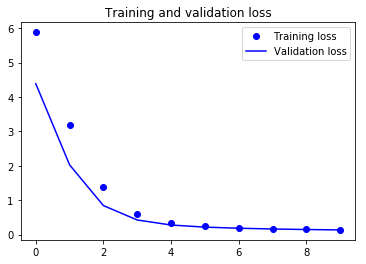

In [39]:
# plot loss curve on validation data
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']

plt.figure()
plt.plot(range(epochs), loss, 'bo', label='Training loss')
plt.plot(range(epochs), val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

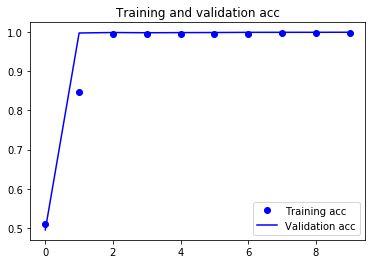

In [41]:
# plot accuracy curve on validation data
acc = autoencoder_train.history['acc']
val_acc = autoencoder_train.history['val_acc']
plt.figure()
plt.plot(range(epochs), acc, 'bo', label='Training acc')
plt.plot(range(epochs), val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.legend()
plt.show()

# Prediction on test data

In [45]:
# test_X
test_data.reshape(-1, 5000)

array([[0.5, 0.5, 0. , ..., 1. , 1. , 1. ],
       [1. , 1. , 1. , ..., 0.5, 0.5, 0.5],
       [1. , 1. , 1. , ..., 0.5, 0.5, 0.5],
       ...,
       [0.5, 0.5, 0.5, ..., 1. , 1. , 1. ],
       [1. , 1. , 1. , ..., 0.5, 1. , 1. ],
       [0.5, 0.5, 0.5, ..., 1. , 0. , 0. ]])

In [46]:
# test_Y
test_Y.reshape(-1, 5000)

array([[0., 0., 0., ..., 1., 1., 1.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [1., 1., 1., ..., 0., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

In [51]:
# predict
predict_data = autoencoder.predict(test_data)
predict_data[predict_data > 0.5] = 1
predict_data[predict_data < 0.5] = 0
predict_data = predict_data.reshape(-1, df.shape[1])
predict_data

array([[0., 0., 0., ..., 1., 1., 1.],
       [1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [56]:
# manunally defined evaluation
mask = test_data.reshape(-1, feature_size) == 0
no_wrong_imp = np.count_nonzero(predict_data[mask] - test_Y[mask].ravel())
acc = 1- no_wrong_imp / test_Y[mask].ravel().shape[0]

print('acc of imputation: ', acc)

acc of imputation:  0.9972004479283315
